In [38]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('loan_data_2007_2014.csv')

In [3]:
print(data.shape)
print(data.columns.values)
data.head()

(466285, 75)
['Unnamed: 0' 'id' 'member_id' 'loan_amnt' 'funded_amnt' 'funded_amnt_inv'
 'term' 'int_rate' 'installment' 'grade' 'sub_grade' 'emp_title'
 'emp_length' 'home_ownership' 'annual_inc' 'verification_status'
 'issue_d' 'loan_status' 'pymnt_plan' 'url' 'desc' 'purpose' 'title'
 'zip_code' 'addr_state' 'dti' 'delinq_2yrs' 'earliest_cr_line'
 'inq_last_6mths' 'mths_since_last_delinq' 'mths_since_last_record'
 'open_acc' 'pub_rec' 'revol_bal' 'revol_util' 'total_acc'
 'initial_list_status' 'out_prncp' 'out_prncp_inv' 'total_pymnt'
 'total_pymnt_inv' 'total_rec_prncp' 'total_rec_int' 'total_rec_late_fee'
 'recoveries' 'collection_recovery_fee' 'last_pymnt_d' 'last_pymnt_amnt'
 'next_pymnt_d' 'last_credit_pull_d' 'collections_12_mths_ex_med'
 'mths_since_last_major_derog' 'policy_code' 'application_type'
 'annual_inc_joint' 'dti_joint' 'verification_status_joint'
 'acc_now_delinq' 'tot_coll_amt' 'tot_cur_bal' 'open_acc_6m' 'open_il_6m'
 'open_il_12m' 'open_il_24m' 'mths_since_rcnt

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
pd.options.display.max_rows = None
data.dtypes

Unnamed: 0                       int64
id                               int64
member_id                        int64
loan_amnt                        int64
funded_amnt                      int64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                      

# Defining Dependent Variable

- Charged Off, Default,Does not meet the credit policy. Status:Charged Off,Late (31-120 days)
- Good loan = 1 and Bad loan = 0 (indicators are mapped differently cause PD beta's should be interpretable. If Betas are negative, it indicates tendency of bad loan)

In [5]:
data['good_bad'] = np.where(data['loan_status'].isin(['Charged Off', 'Default',
                                                               'Does not meet the credit policy. Status:Charged Off',
                                                               'Late (31-120 days)']), 0, 1)

In [6]:
data['good_bad'].value_counts(dropna=False)

1    415317
0     50968
Name: good_bad, dtype: int64

# Data Exploration

## Bi-variate Analysis

In [7]:
def bivariate_analysis(df_1,independent_var, dependent_var):
    df = df_1.copy()
    
    if df[independent_var].dtype == 'object':
        observations = df.groupby(independent_var).size().reset_index(name = '#Loans')
        good_loans = df.groupby(independent_var)[dependent_var].sum().reset_index(name = '#Good Loans')
        summary = pd.merge(observations,good_loans,on=independent_var,how='inner')
        summary['#Bad Loans'] = summary['#Loans'] - summary['#Good Loans']
        summary['%Bad Loans'] = round(summary['#Bad Loans']*100/summary['#Loans'],2)
        summary.sort_values(independent_var,inplace= True)

        
        plt.figure(figsize=(10,5))
        plt.plot(summary[independent_var],summary['%Bad Loans'],marker = 'o',linestyle = '-',color = 'b')
        plt.title(f'Bad loan trend by {independent_var}')
        plt.xlabel(independent_var)
        plt.xticks(rotation = 45)
        plt.ylabel('%Bad Loans')
        plt.grid(True)
        plt.show()       
        
        return summary
        
    else:
        df[f'{independent_var}_Bins'] = pd.qcut(df[independent_var],q = 10,duplicates='drop')
        df[f'{independent_var}_Bins_Range'] = df[f'{independent_var}_Bins'].apply(lambda x :f"{int(x.left)} - {int(x.right)}" if pd.notnull(x) else "NaN")
        observations = df.groupby(f'{independent_var}_Bins_Range').size().reset_index(name = '#Loans')
        good_loans = df.groupby(f'{independent_var}_Bins_Range')[dependent_var].sum().reset_index(name = '#Good Loans')
        summary = pd.merge(observations,good_loans,on=f'{independent_var}_Bins_Range',how='inner')
        summary['#Bad Loans'] = summary['#Loans'] - summary['#Good Loans']
        summary['%Bad Loans'] = round(summary['#Bad Loans']*100/summary['#Loans'],2)
        summary.sort_values(f'{independent_var}_Bins_Range',inplace= True)
        
        plt.figure(figsize=(10,5))
        plt.plot(summary[f'{independent_var}_Bins_Range'],summary['%Bad Loans'],marker = 'o',linestyle = '-',color = 'b')
        plt.title(f'Bad loan trend by {independent_var}')
        plt.xlabel(independent_var)
        plt.xticks(rotation = 45)
        plt.ylabel('%Bad Loans')
        plt.grid(True)
        plt.show()  
        
        return summary

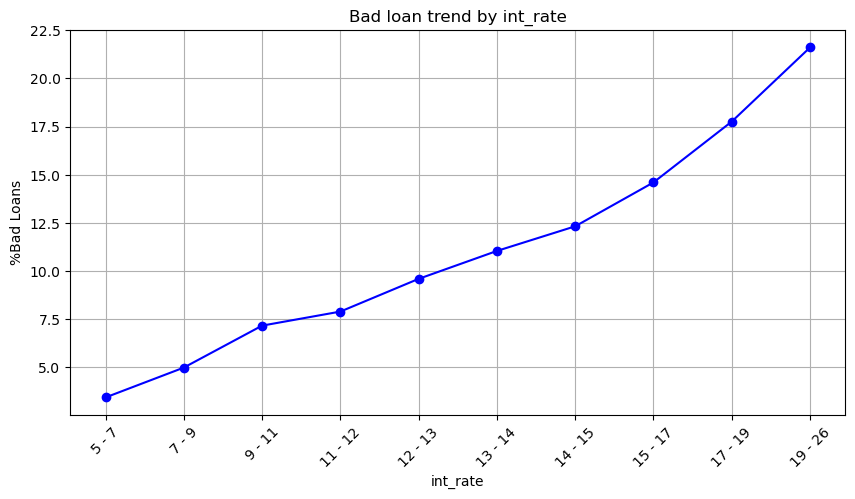

,int_rate_Bins_Range,#Loans,#Good Loans,#Bad Loans,%Bad Loans
0,5 - 7,53473,51641,1832,3.43
1,7 - 9,39944,37956,1988,4.98
2,9 - 11,46789,43440,3349,7.16
3,11 - 12,47073,43357,3716,7.89
4,12 - 13,47227,42697,4530,9.59
5,13 - 14,45670,40629,5041,11.04
6,14 - 15,49407,43319,6088,12.32
7,15 - 17,50361,43009,7352,14.60
8,17 - 19,41159,33851,7308,17.76
9,19 - 26,45182,35418,9764,21.61


In [10]:
bivariate_analysis(data,'int_rate', 'good_bad')

# Exclusions

## All Null values

In [11]:
def get_null_columns(df):

    all_nulls = df.isnull().all()

    null_columns = all_nulls[all_nulls].index.tolist()

    return null_columns

In [12]:
null_columns = get_null_columns(data)

In [13]:
null_columns

['annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [14]:
data.drop(columns = null_columns, inplace= True)

In [15]:
data.shape

(466285, 59)

## Constant Value

In [16]:
def get_constant_columns(df):

    constant_columns = []

    for column in df.columns:
        if df[column].nunique() == 1:  
            constant_columns.append(column)

    return constant_columns

In [17]:
constant_column = get_constant_columns(data)

In [18]:
constant_column

['policy_code', 'application_type']

In [19]:
data.drop(columns= constant_column,inplace= True)

In [20]:
data.shape

(466285, 57)

## ID type column

In [21]:
id_columns =  ['url','desc','title','zip_code', 'Unnamed: 0','member_id','id']

In [22]:
data.drop(columns = id_columns, inplace = True)

## No Trend

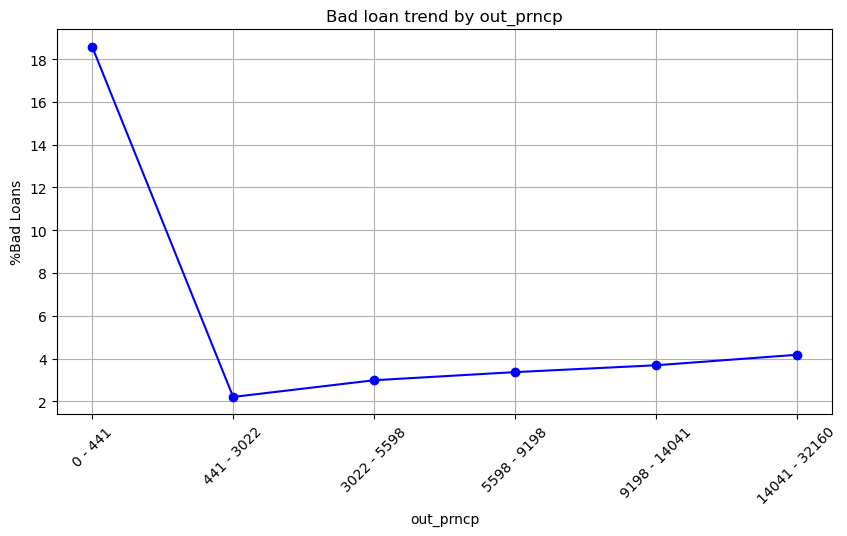

,out_prncp_Bins_Range,#Loans,#Good Loans,#Bad Loans,%Bad Loans
0,0 - 441,233143,189841,43302,18.57
1,441 - 3022,46632,45601,1031,2.21
2,3022 - 5598,46624,45231,1393,2.99
3,5598 - 9198,46629,45056,1573,3.37
4,9198 - 14041,46628,44909,1719,3.69
5,14041 - 32160,46629,44679,1950,4.18


In [23]:
bivariate_analysis(data,'out_prncp', 'good_bad')

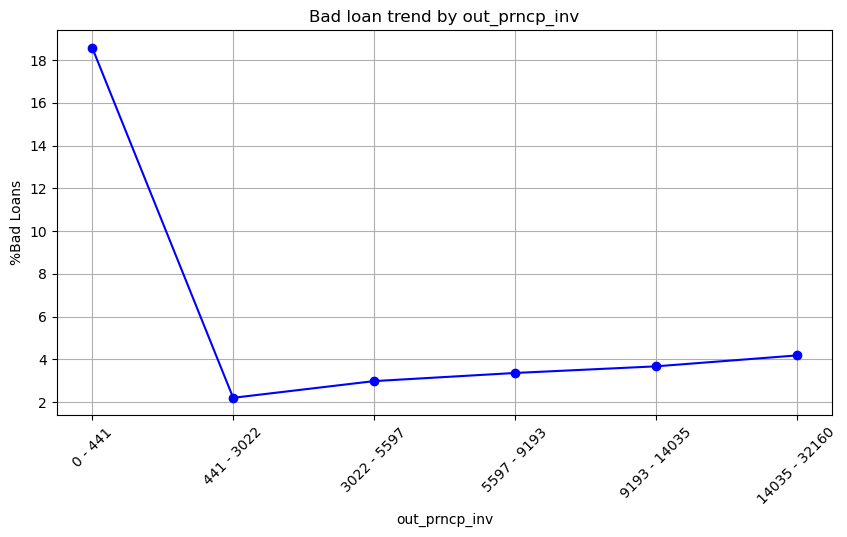

,out_prncp_inv_Bins_Range,#Loans,#Good Loans,#Bad Loans,%Bad Loans
0,0 - 441,233144,189842,43302,18.57
1,441 - 3022,46627,45596,1031,2.21
2,3022 - 5597,46628,45232,1396,2.99
3,5597 - 9193,46634,45063,1571,3.37
4,9193 - 14035,46623,44907,1716,3.68
5,14035 - 32160,46629,44677,1952,4.19


In [24]:
bivariate_analysis(data,'out_prncp_inv', 'good_bad')

In [25]:
data.drop(columns = ['out_prncp','out_prncp_inv'], inplace = True)

In [26]:
data.shape

(466285, 48)

# General Preprocessing of Features

## Continuous Variable

In [27]:
data['emp_length_int'] = data['emp_length'].str.replace('\+ years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace('< 1 year', str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace('n/a',  str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace(' years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace(' year', '')

In [28]:
data['emp_length_int'] = pd.to_numeric(data['emp_length_int'])

In [29]:
data['earliest_cr_line_date'] = pd.to_datetime(data['earliest_cr_line'], format = '%b-%y')

In [30]:
data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))

In [31]:
data['mths_since_earliest_cr_line'][data['mths_since_earliest_cr_line'] < 0] = data['mths_since_earliest_cr_line'].max()

In [32]:
data['term_int'] = pd.to_numeric(data['term'].str.replace(' months', ''))

In [33]:
data['issue_d_date'] = pd.to_datetime(data['issue_d'], format = '%b-%y')
data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['issue_d_date']) / np.timedelta64(1, 'M')))
data['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

## Discrete Variables

In [34]:
loan_data_dummies = [pd.get_dummies(data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]

In [35]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [36]:
data = pd.concat([data, loan_data_dummies], axis = 1)

In [37]:
data.shape

(466285, 180)

Note on why we do imputation after splitting 

- The best practice for imputing to avoid leakage is as follows.  First, split the data into training and validation sets.  For mean imputation, find the training data means, then impute the training means for missing values in both the training and validation sets.

## Splitting the data

In [39]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(data.drop('good_bad', axis = 1), data['good_bad'], test_size = 0.3, random_state = 42)

In [40]:
loan_data_inputs_train.shape

(326399, 179)

In [41]:
loan_data_targets_train.shape

(326399,)

In [42]:
loan_data_inputs_test.shape

(139886, 179)

In [43]:
loan_data_targets_test.shape

(139886,)

In [44]:
loan_data_inputs_train.to_csv('loan_data_inputs_train.csv', index=False)
loan_data_targets_train.to_csv('loan_data_targets_train.csv', index=False)
loan_data_inputs_test.to_csv('loan_data_inputs_test.csv', index=False)
loan_data_targets_test.to_csv('loan_data_targets_test.csv', index=False)